# CellScatter Formfactor to TotalDensity deep learning model notebook

We first need to get many different imports to create usable data, train models and test them. It is recommended to create a python virtual enviroment and then install the required packages using the requirements.txt file.  

In [1]:
import statistics as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from collections import Counter
from scipy.signal import find_peaks
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import matplotlib.colors as colors
from sklearn.manifold import Isomap
import keras_tuner
from keras_tuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam

First we will need to save the required data into pandas dataframes for easier manipulation. The simulation FF and TD data are simply loaded into dataframes, while the experimental FF data requires padding using zeros to 1000 long vectors to be used by the model trained on simulation data with standard 1000 long vectors. 

In [2]:
sim_FF_df = pd.read_csv('form_factors.csv')
sim_TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
sim_TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

sim_FF_df = sim_FF_df.transpose()
sim_TD_x_df = sim_TD_x_df.transpose()
sim_TD_y_df = sim_TD_y_df.transpose()

exp_FF = pd.read_json('experiment_formfactors.json')
exp_FF_list = []
for i in range(0,exp_FF.shape[1]):
    exp_FF_list.append(np.concatenate((exp_FF.iloc[1,i], np.zeros(1000 - len(exp_FF.iloc[1,i])))))
        
exp_FF_df = pd.DataFrame(exp_FF_list)
exp_FF_df = exp_FF_df.transpose()

It is highly recommended for people unfamiliar with the data to see it before continuing further, which is why the following blocks will show the data we will be using their pandas table representations.

In [10]:
sim_FF_df

,0,1,2,3,4,5,6,7,8,9,...,603,604,605,606,607,608,609,610,611,612
0,158.700313,23.453699,71.950184,41.881901,26.452318,11.047131,44.099359,32.289559,35.088986,68.905183,...,30.323867,39.633213,15.273621,62.063384,36.709497,120.551176,23.179887,22.873782,77.699142,46.556570
1,158.640037,23.425170,71.915288,41.858587,26.419103,11.022817,44.122664,32.258483,35.045804,68.876884,...,30.286651,39.617226,15.246616,62.023428,36.673243,120.504543,23.152669,22.847299,77.662203,46.532400
2,158.459238,23.339597,71.810614,41.788653,26.319475,10.949886,44.192567,32.165269,34.916287,68.791997,...,30.175019,39.569268,15.165614,61.903579,36.564501,120.364663,23.071029,22.767861,77.551407,46.459897
3,158.158008,23.197017,71.636207,41.672126,26.153484,10.828371,44.309036,32.009958,34.700512,68.650555,...,29.989024,39.489352,15.030651,61.703902,36.383333,120.131606,22.935006,22.635501,77.366811,46.339087
4,157.736499,22.997497,71.392140,41.509050,25.921215,10.658322,44.472015,31.792620,34.398613,68.452611,...,29.728750,39.377495,14.841788,61.424503,36.129841,119.805483,22.744663,22.450279,77.108512,46.170013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,17.310329,3.131684,1.627084,1.268836,6.549238,0.638636,5.765008,8.441597,13.180741,0.440554,...,2.535038,7.959169,0.784373,1.926625,3.712288,2.097589,10.944315,2.326322,0.094115,4.287337
996,17.359571,3.161219,1.696287,1.293176,6.484021,0.574354,5.846652,8.470322,12.958096,0.420413,...,2.529914,7.882230,0.806052,1.846028,3.648188,2.114517,10.943840,2.339834,0.095271,4.316069
997,17.403357,3.190445,1.765104,1.317745,6.417372,0.510177,5.926353,8.496613,12.733305,0.400530,...,2.528256,7.804138,0.827463,1.768341,3.585205,2.130676,10.938560,2.355930,0.096396,4.342577
998,17.441690,3.219298,1.833502,1.342507,6.349330,0.446154,6.004078,8.520465,12.506490,0.381014,...,2.529921,7.724918,0.848597,1.693578,3.523357,2.146066,10.928482,2.374578,0.097494,4.366867


In [9]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,603,604,605,606,607,608,609,610,611,612
0,333.204244,334.485664,340.298044,334.684611,332.848038,336.100431,351.842860,330.512511,337.266229,332.624183,...,329.131857,328.493013,338.053097,332.910187,336.384540,330.493742,328.922594,330.865940,329.636917,322.430402
1,333.566343,334.232327,340.249833,334.350987,333.289027,335.519065,350.935144,330.516524,337.318158,332.727117,...,329.797640,328.747349,338.117668,332.806640,336.822260,330.482033,329.448368,331.141939,329.756934,324.831431
2,333.731060,333.956931,340.185331,334.168397,333.446321,335.208764,350.600132,330.427115,337.477778,332.762805,...,329.878943,328.742041,338.130676,332.756829,336.838387,330.462405,329.307910,331.286935,329.805601,326.176001
3,333.822123,333.782696,340.138090,334.099749,333.444878,335.105242,350.630093,330.351033,337.613346,332.764355,...,329.660162,328.538288,338.120790,332.805368,336.754824,330.455435,328.968759,331.357395,329.813347,326.721055
4,333.888462,333.739810,340.116558,334.106518,333.372566,335.141254,350.836216,330.334379,337.668212,332.753040,...,329.388288,328.196835,338.105252,332.922401,336.719547,330.466258,328.711676,331.378835,329.802678,326.715502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,333.778670,333.763426,340.186997,334.106887,333.289838,334.898850,350.553593,330.263046,337.618389,332.786905,...,329.196610,328.563470,338.087262,332.971975,336.809905,330.430037,329.568313,331.244414,329.786218,325.799012
196,333.729730,333.840736,340.251529,334.089817,333.339024,334.943515,350.389940,330.073637,337.514903,332.809683,...,329.381779,328.876883,338.073907,333.016986,336.999441,330.449168,329.557337,330.907225,329.802986,325.998720
197,333.669431,333.876643,340.287847,334.036981,333.398144,335.151591,350.177928,329.998734,337.359402,332.809623,...,329.401901,329.035338,338.069590,333.048410,337.091830,330.465254,329.381783,330.670172,329.805961,326.142870
198,333.544270,333.788974,340.219963,333.938143,333.428262,335.595932,349.928119,330.150935,337.176497,332.769615,...,329.039184,328.946697,338.087988,332.961431,336.840729,330.450025,328.951252,330.704654,329.773324,326.133732


In [11]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,603,604,605,606,607,608,609,610,611,612
0,333.204244,334.485664,340.298044,334.684611,332.848038,336.100431,351.842860,330.512511,337.266229,332.624183,...,329.131857,328.493013,338.053097,332.910187,336.384540,330.493742,328.922594,330.865940,329.636917,322.430402
1,333.566343,334.232327,340.249833,334.350987,333.289027,335.519065,350.935144,330.516524,337.318158,332.727117,...,329.797640,328.747349,338.117668,332.806640,336.822260,330.482033,329.448368,331.141939,329.756934,324.831431
2,333.731060,333.956931,340.185331,334.168397,333.446321,335.208764,350.600132,330.427115,337.477778,332.762805,...,329.878943,328.742041,338.130676,332.756829,336.838387,330.462405,329.307910,331.286935,329.805601,326.176001
3,333.822123,333.782696,340.138090,334.099749,333.444878,335.105242,350.630093,330.351033,337.613346,332.764355,...,329.660162,328.538288,338.120790,332.805368,336.754824,330.455435,328.968759,331.357395,329.813347,326.721055
4,333.888462,333.739810,340.116558,334.106518,333.372566,335.141254,350.836216,330.334379,337.668212,332.753040,...,329.388288,328.196835,338.105252,332.922401,336.719547,330.466258,328.711676,331.378835,329.802678,326.715502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,333.778670,333.763426,340.186997,334.106887,333.289838,334.898850,350.553593,330.263046,337.618389,332.786905,...,329.196610,328.563470,338.087262,332.971975,336.809905,330.430037,329.568313,331.244414,329.786218,325.799012
196,333.729730,333.840736,340.251529,334.089817,333.339024,334.943515,350.389940,330.073637,337.514903,332.809683,...,329.381779,328.876883,338.073907,333.016986,336.999441,330.449168,329.557337,330.907225,329.802986,325.998720
197,333.669431,333.876643,340.287847,334.036981,333.398144,335.151591,350.177928,329.998734,337.359402,332.809623,...,329.401901,329.035338,338.069590,333.048410,337.091830,330.465254,329.381783,330.670172,329.805961,326.142870
198,333.544270,333.788974,340.219963,333.938143,333.428262,335.595932,349.928119,330.150935,337.176497,332.769615,...,329.039184,328.946697,338.087988,332.961431,336.840729,330.450025,328.951252,330.704654,329.773324,326.133732


In [8]:
exp_FF_df

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.69045,0.94799,0.57109,0.67692,0.44433,0.46873,0.65311,0.45304,0.23598,0.940814,...,0.79496,0.68120,0.66807,1.738367,0.899451,0.964967,0.54543,-0.8847,0.21422,0.14883
1,0.70439,0.97626,0.59010,0.68742,0.47560,0.49742,0.66791,0.48837,0.24655,0.980243,...,0.82431,0.71829,0.67950,1.779776,0.938214,0.997898,0.54396,-1.1330,0.22350,0.17136
2,0.72295,1.00110,0.62122,0.70990,0.50405,0.52507,0.69012,0.51829,0.25462,1.019736,...,0.86973,0.75839,0.68633,1.821240,0.977162,1.030965,0.55720,-1.3247,0.23718,0.19440
3,0.74044,1.02330,0.65866,0.73696,0.53155,0.55207,0.71822,0.54591,0.26577,1.059275,...,0.90282,0.79412,0.70381,1.862742,1.016269,1.064145,0.57532,-1.4694,0.25745,0.20896
4,0.75144,1.04460,0.67874,0.76188,0.55945,0.57587,0.73553,0.56874,0.28433,1.098842,...,0.93702,0.82500,0.71839,1.904254,1.055524,1.097427,0.59354,-1.5400,0.26064,0.22275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0000,0.00000,0.00000
996,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0000,0.00000,0.00000
997,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0000,0.00000,0.00000
998,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0000,0.00000,0.00000


(490, 1000)
(490, 400)
(123, 1000)
(123, 400)
(36, 1000)


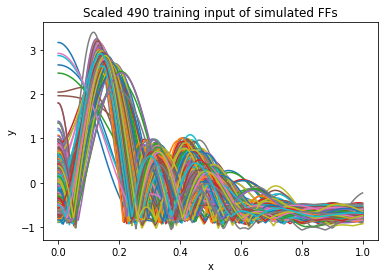

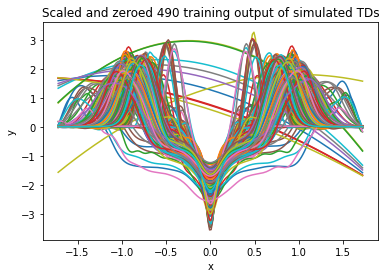

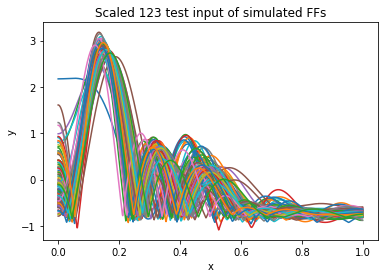

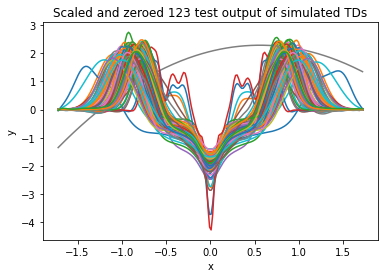

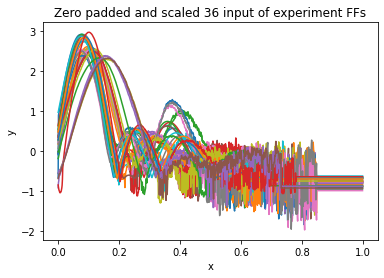

In [57]:
def data_plots(train_input, train_output, test_input, test_output, exp_input): 
    train_sim_FF_df = pd.DataFrame(train_input)
    for row in train_sim_FF_df.iloc:
        plt.plot(np.arange(0,1,0.001),row)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scaled ' + str(train_sim_FF_df.shape[0]) + ' training input of simulated FFs')
    plt.show()
    
    train_sim_TD_df = pd.DataFrame(train_output)
    for row in train_sim_TD_df.iloc:
        plt.plot(row[:200],row[200:])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scaled and zeroed ' + str(train_sim_TD_df.shape[0]) + ' training output of simulated TDs')
    plt.show()
    
    test_sim_FF_df = pd.DataFrame(test_input)
    for row in test_sim_FF_df.iloc:
        plt.plot(np.arange(0,1,0.001),row)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scaled ' + str(test_sim_FF_df.shape[0]) + ' test input of simulated FFs')
    plt.show()
    
    test_sim_TD_df = pd.DataFrame(test_output)
    for row in test_sim_TD_df.iloc:
        plt.plot(row[:200],row[200:])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scaled and zeroed ' + str(test_sim_TD_df.shape[0]) + ' test output of simulated TDs')
    plt.show()
    
    exp_FF_df = pd.DataFrame(exp_input)
    for row in exp_FF_df.iloc:
        plt.plot(np.arange(0,1,0.001),row)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Zero padded and scaled ' + str(exp_FF_df.shape[0]) + ' input of experiment FFs')
    plt.show()

def reduced_FF_to_TD_preprocessing(exp_FF_df, sim_FF_df, sim_TD_x_df, sim_TD_y_df):
    random.seed(42)
    train = random.sample(list(sim_FF_df.columns),int(round(613*0.8,0)))
    test = []
    for number in list(sim_FF_df.columns):
        if not number in train:
            test.append(number)
    
    exp_FF_scaled_values = []
    for column in exp_FF_df.columns:
        exp_FF_scaled_values.append((exp_FF_df[column] - exp_FF_df[column].mean()) / exp_FF_df[column].std())
    
    exp_FF_scaled_df = pd.DataFrame(exp_FF_scaled_values)
    exp_FF_scaled_df = exp_FF_scaled_df.transpose()
    exp_FF_scaled_df.columns = exp_FF_df.columns
             
    FF_scaled_values = []
    for column in sim_FF_df.columns:
        FF_scaled_values.append((sim_FF_df[column] - sim_FF_df[column].mean()) / sim_FF_df[column].std())
    
    sim_FF_scaled_df = pd.DataFrame(FF_scaled_values)
    sim_FF_scaled_df = sim_FF_scaled_df.transpose()
    sim_FF_scaled_df.columns = sim_FF_df.columns
            
    sim_TD_x_df = sim_TD_x_df
    TD_x_scaled_values = []
    for column in sim_TD_x_df.columns:
        TD_x_scaled_values.append((sim_TD_x_df[column] - sim_TD_x_df[column].mean()) / sim_TD_x_df[column].std())
        
    TD_x_scaled_df = pd.DataFrame(TD_x_scaled_values)
    TD_x_scaled_df = TD_x_scaled_df.transpose()
    TD_x_scaled_df.columns = sim_TD_x_df.columns
    
    TD_y_scaled_values = []
    for column in sim_TD_y_df.columns:
        TD_y_scaled_values.append((sim_TD_y_df[column] - sim_TD_y_df[column].mean()) / sim_TD_y_df[column].std())
    
    TD_y_scaled_df = pd.DataFrame(TD_y_scaled_values)
    TD_y_scaled_df = TD_y_scaled_df.transpose()
    TD_y_scaled_df.columns = sim_TD_y_df.columns
    
    zeroing = round((TD_y_scaled_df.iloc[0]+TD_y_scaled_df.iloc[-1])/2,3)
    TD_y_scaled_df = TD_y_scaled_df.subtract(zeroing)
             
    sim_TD_df = pd.concat([TD_x_scaled_df, TD_y_scaled_df], axis=0)
    train_input = sim_FF_scaled_df[train].transpose().astype(np.float32)
    train_output = sim_TD_df[train].transpose().values.astype(np.float32)
    test_input = sim_FF_scaled_df[test].transpose().astype(np.float32)
    test_output = sim_TD_df[test].transpose().values.astype(np.float32)
    exp_input = exp_FF_scaled_df.transpose().values.astype(np.float32)
            
    print(train_input.shape)
    print(train_output.shape)
    print(test_input.shape)
    print(test_output.shape)
    print(exp_input.shape)
     
    return train_input, train_output, test_input, test_output, exp_input 

train_input, train_output, test_input, test_output, exp_input = reduced_FF_to_TD_preprocessing(exp_FF_df, sim_FF_df, sim_TD_x_df, sim_TD_y_df)
data_plots(train_input, train_output, test_input, test_output, exp_input)

In [58]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for test data of ' + str(amount))
    plt.show()
    
    return [average_loss, mode_loss, median_loss]

def simulation_plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(actual)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = actual[number][0:length]
        y_2 = actual[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = actual[index][0:length].tolist()
        t_y = actual[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[0]][0:length]
    y_1 = prediction[train[0]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[0]][0:length]
    y_2 = actual[train[0]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[0]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[0]],prediction[train[0]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[4]][0:length]
    y_1 = prediction[train[4]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[4]][0:length]
    y_2 = actual[train[4]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[4]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[4]],prediction[train[4]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[9]][0:length]
    y_1 = prediction[train[9]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[9]][0:length]
    y_2 = actual[train[9]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[9]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[9]],prediction[train[9]])))
    
def experiment_predictions(prediction):
    random.seed(42)
    train = random.sample(range(0,len(prediction)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x = prediction[number][0:length]
        y = prediction[number][length:]
        plt.plot(x,y,c='b')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random experiment predictions')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b')
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction on experiment data')
    plt.show()

Used time: 17.00014352798462 seconds


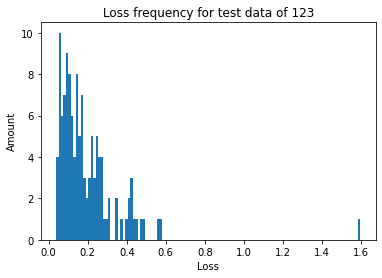

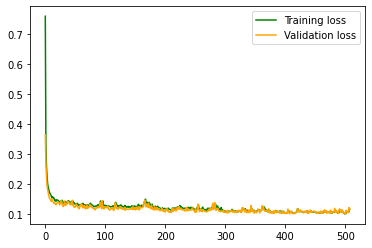

Loss average is: 0.1944993278830764
Loss mode is: [(0.09041, 2), (0.09635, 1), (0.57878, 1), (0.41313, 1), (0.2922, 1), (0.21778, 1), (0.04398, 1), (0.13561, 1), (1.5971, 1), (0.24097, 1)]
Loss median is: 0.15119


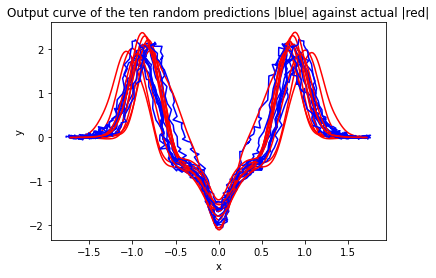

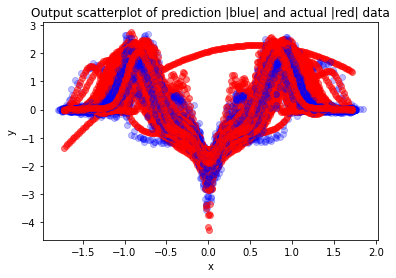

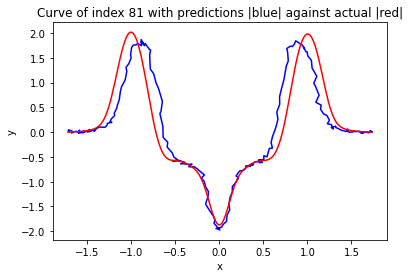

The loss of the curve 0.2727572317987416


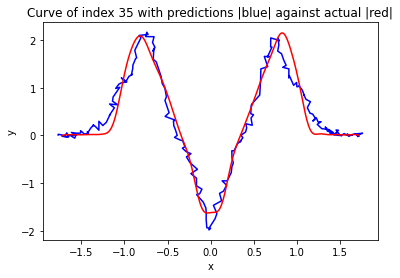

The loss of the curve 0.18655241239957404


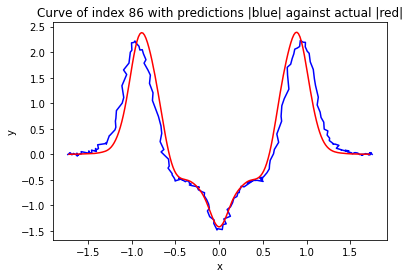

The loss of the curve 0.168429166720723


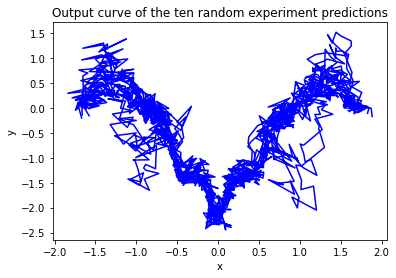

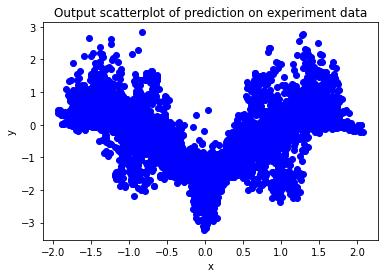

In [59]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1000, activation='relu')(inputs)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=128, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(model.predict(exp_input))

Trial 90 Complete [00h 00m 25s]
loss: 0.13212166726589203

Best loss So Far: 0.11830209195613861
Total elapsed time: 00h 10m 27s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 4, 'dense_0_units': 3000, 'dropout_0': 0.05, 'learning_rate': 0.001, 'dense_1_units': 2000, 'dropout_1': 0.1, 'dense_2_units': 500, 'dropout_2': 0.25, 'dense_3_units': 2000, 'dropout_3': 0.25, 'dense_4_units': 1000, 'dropout_4': 0.15000000000000002, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0077'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3000)              3003000   
_________________________________________________________________
dropout (Dropout)            (None, 3000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2000)

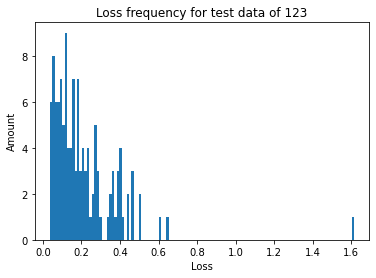

Loss average is: 0.21135638786838476
Loss mode is: [(0.15508, 1), (0.60341, 1), (0.4064, 1), (0.19872, 1), (0.40455, 1), (0.07921, 1), (0.20127, 1), (1.61527, 1), (0.2932, 1), (0.11096, 1)]
Loss median is: 0.16019


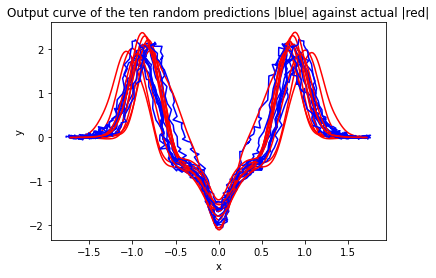

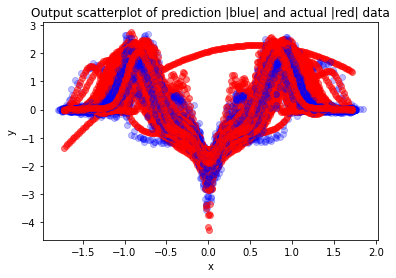

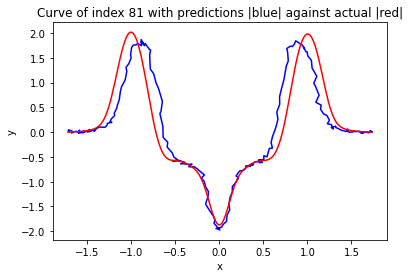

The loss of the curve 0.2727572317987416


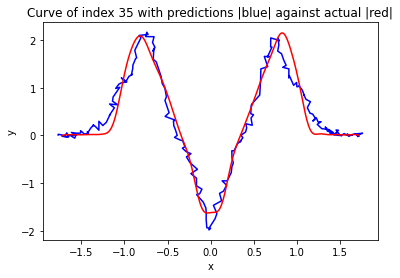

The loss of the curve 0.18655241239957404


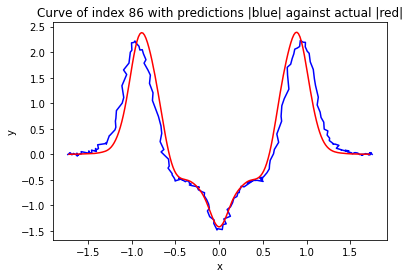

The loss of the curve 0.168429166720723


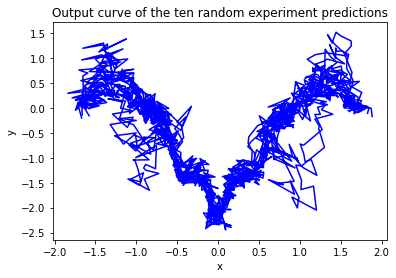

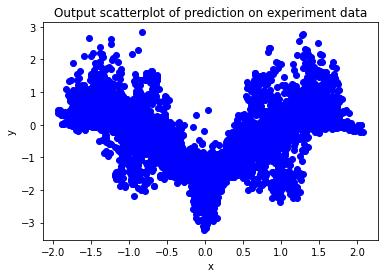

In [61]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=3000, step=500), 
                               activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    
    model.compile(optimizer=Adam(amsgrad=True, learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),loss='mean_absolute_error')
    
    return model

tuner = Hyperband(
    build_model,
    objective='loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_10')

tuner.search(train_input, train_output,
             epochs=50,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(model.predict(exp_input))

Used time: 165.54706573486328 seconds


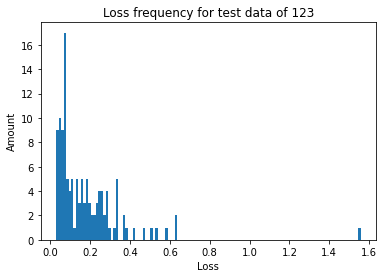

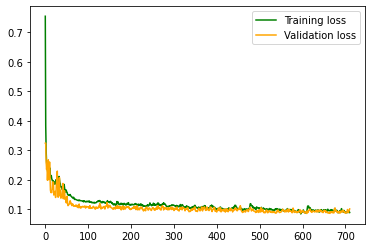

Loss average is: 0.179408767966657
Loss mode is: [(0.16877, 1), (0.6322, 1), (0.3669, 1), (0.24104, 1), (0.28943, 1), (0.06896, 1), (0.25605, 1), (1.55664, 1), (0.28036, 1), (0.06939, 1)]
Loss median is: 0.12969


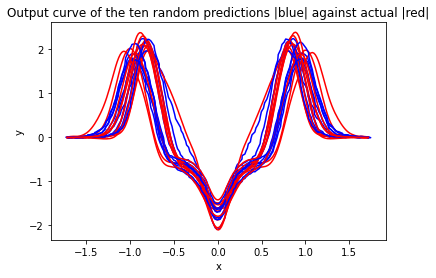

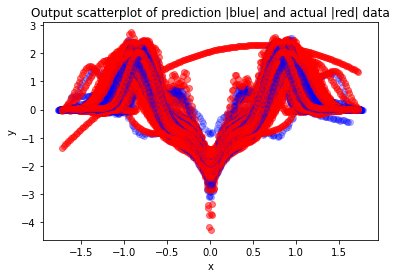

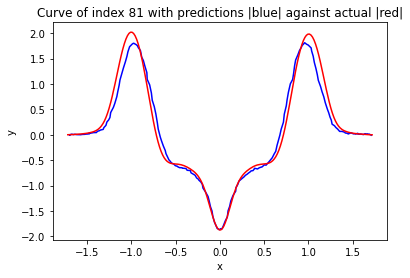

The loss of the curve 0.10474304674719154


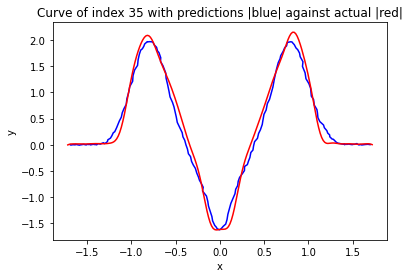

The loss of the curve 0.1194096203260913


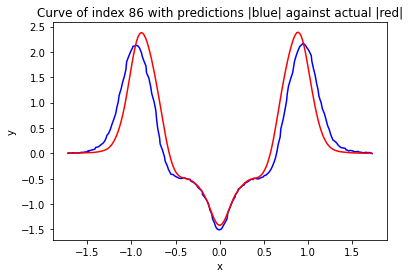

The loss of the curve 0.23256295488404977


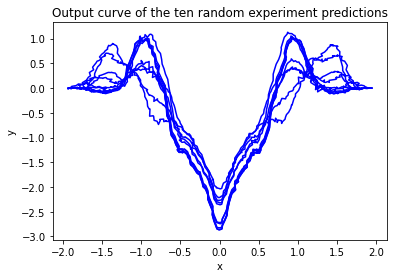

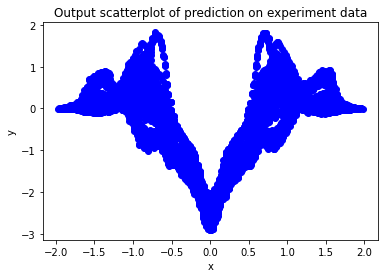

In [63]:
from keras import regularizers

general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(amsgrad=True, learning_rate=1e-3), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=128, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(model.predict(exp_input))

Used time: 77.99396705627441 seconds


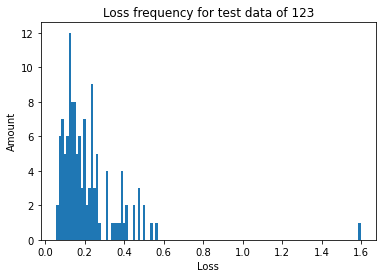

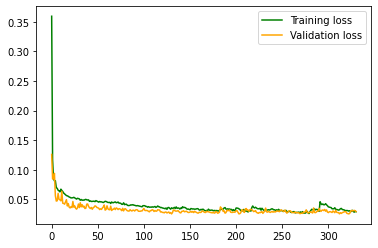

Loss average is: 0.2200239374958195
Loss mode is: [(0.19738, 1), (0.55828, 1), (0.47063, 1), (0.27051, 1), (0.35664, 1), (0.06933, 1), (0.18054, 1), (1.59654, 1), (0.307, 1), (0.12595, 1)]
Loss median is: 0.17251


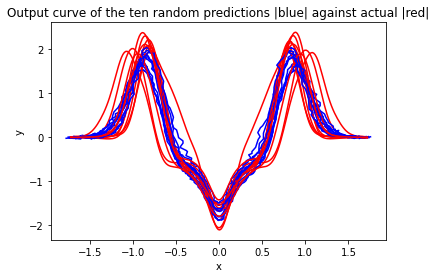

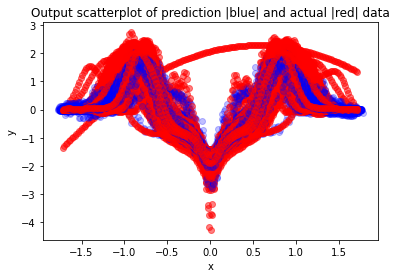

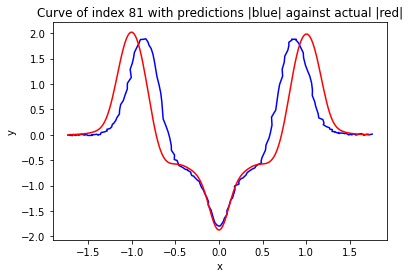

The loss of the curve 0.3859674130358576


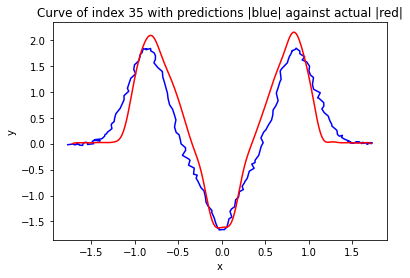

The loss of the curve 0.25787683942631856


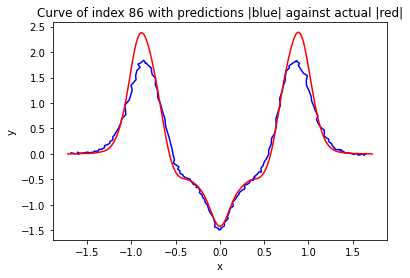

The loss of the curve 0.15767494067964172


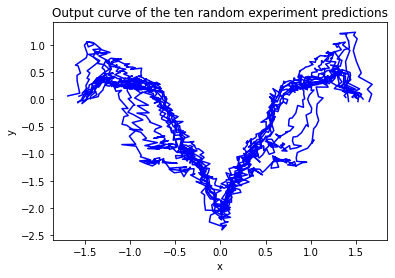

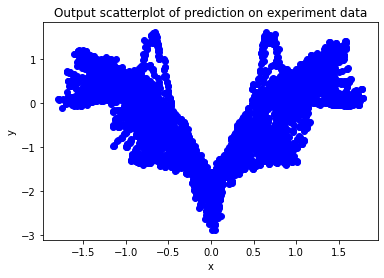

In [64]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(amsgrad=True, learning_rate=1e-3), loss='huber_loss')

history = model.fit(train_input, train_output, batch_size=128, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(model.predict(exp_input))

Used time: 140.44960618019104 seconds


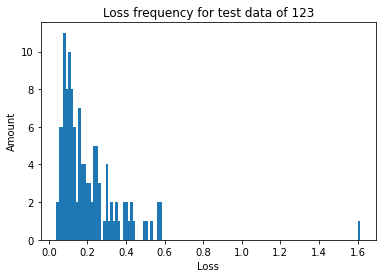

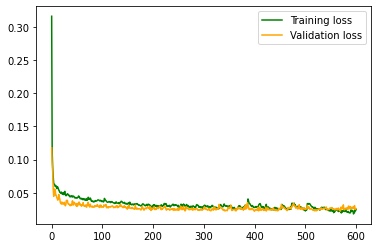

Loss average is: 0.2091524707590656
Loss mode is: [(0.34686, 1), (0.58704, 1), (0.39649, 1), (0.23437, 1), (0.39145, 1), (0.08368, 1), (0.08388, 1), (1.6149, 1), (0.22098, 1), (0.12418, 1)]
Loss median is: 0.15739


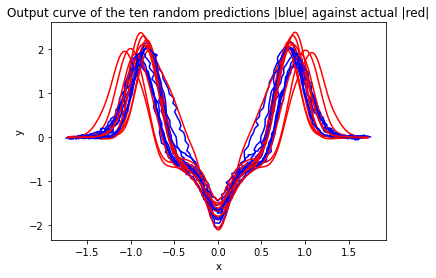

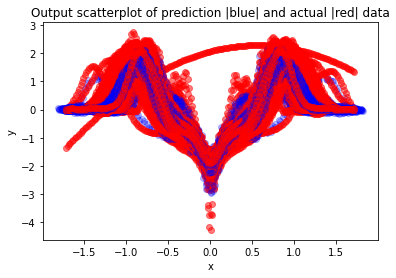

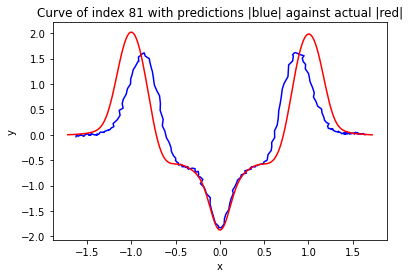

The loss of the curve 0.23335393264857626


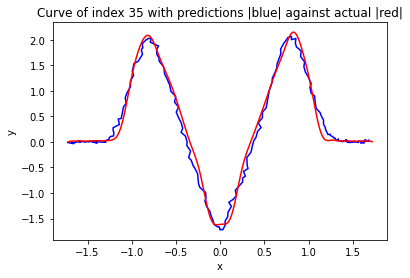

The loss of the curve 0.10387932330008827


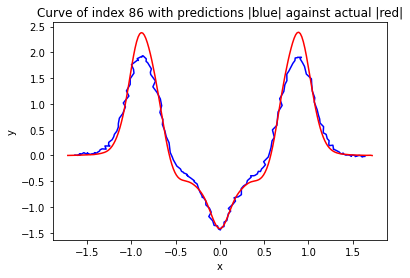

The loss of the curve 0.19601601490995801


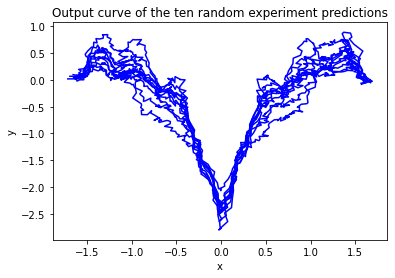

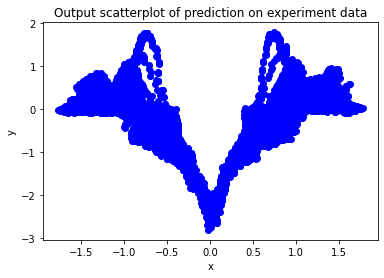

In [65]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(amsgrad=True, learning_rate=1e-3), loss='log_cosh')

history = model.fit(train_input, train_output, batch_size=128, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(model.predict(exp_input))

Used time: 115.83904337882996 seconds


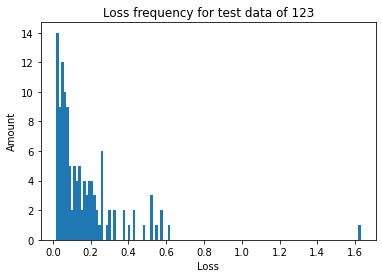

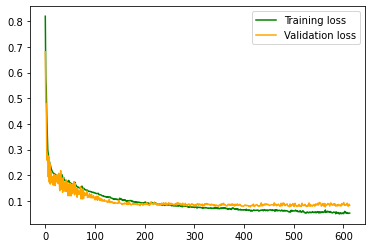

Loss average is: 0.1681412409519704
Loss mode is: [(0.19849, 1), (0.57681, 1), (0.13297, 1), (0.19903, 1), (0.51612, 1), (0.02109, 1), (0.17093, 1), (1.6291, 1), (0.2135, 1), (0.10983, 1)]
Loss median is: 0.10983


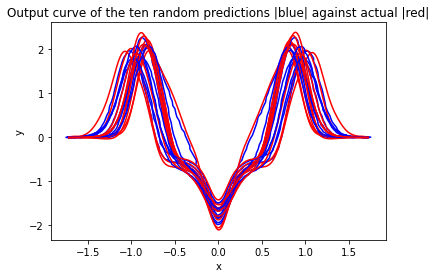

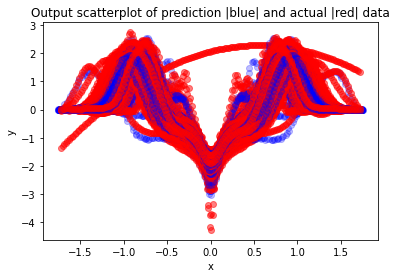

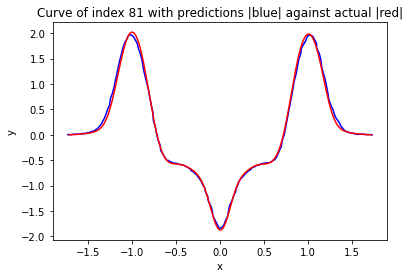

The loss of the curve 0.028333450658472644


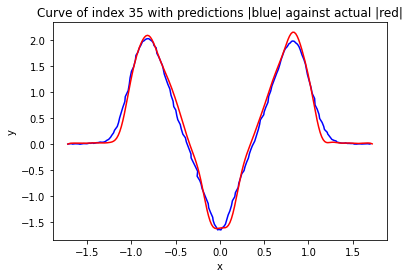

The loss of the curve 0.11428323516089138


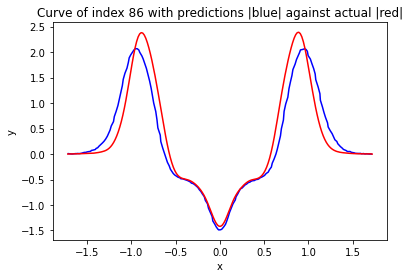

The loss of the curve 0.24194267092157204


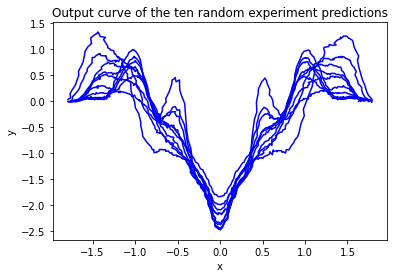

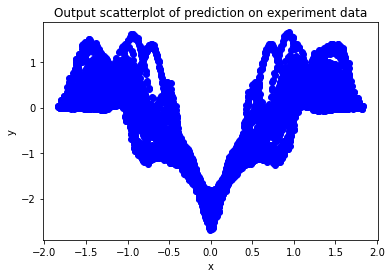

In [66]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(amsgrad=True, learning_rate=1e-3), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=200, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(model.predict(exp_input))

Used time: 236.66352438926697 seconds


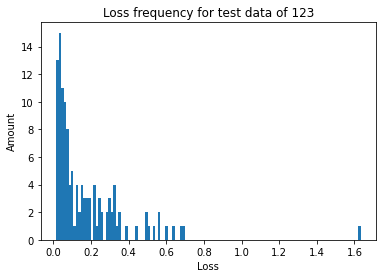

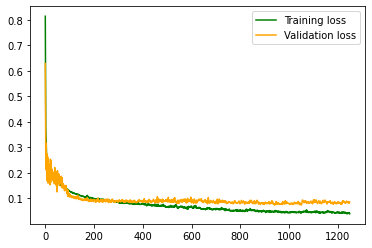

Loss average is: 0.1745143054825392
Loss mode is: [(0.17626, 1), (0.60277, 1), (0.03682, 1), (0.21279, 1), (0.48992, 1), (0.02227, 1), (0.12502, 1), (1.63209, 1), (0.24522, 1), (0.07942, 1)]
Loss median is: 0.09551


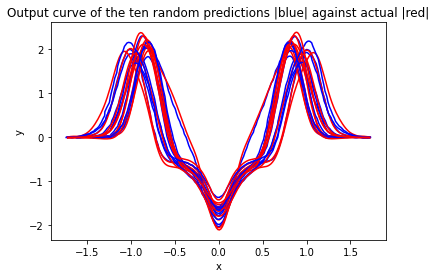

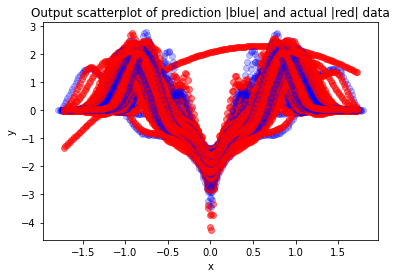

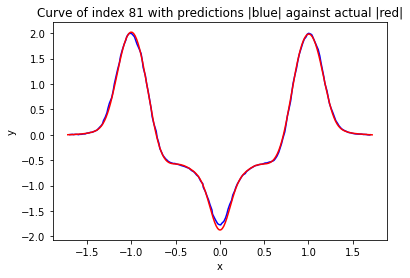

The loss of the curve 0.04476186693639375


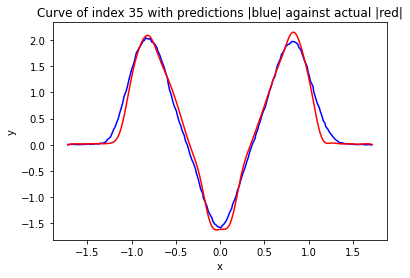

The loss of the curve 0.09822395923737127


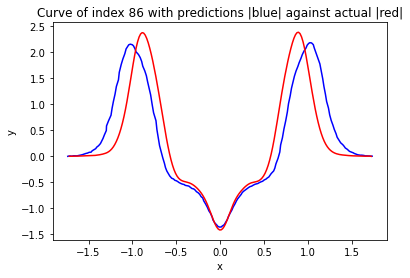

The loss of the curve 0.34210574093770496


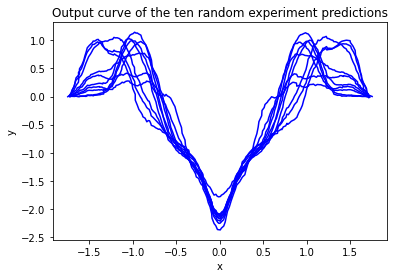

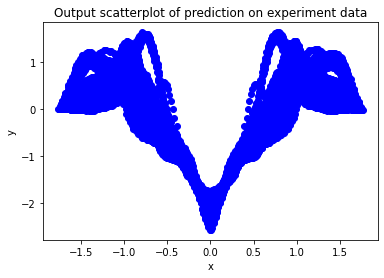

In [67]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(amsgrad=True, learning_rate=1e-3), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(model.predict(exp_input))